In [ ]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_tavily import TavilySearch
from uuid import uuid4
import json
import os
load_dotenv()


In [18]:
model = ChatOpenAI(
    model="llama-3.1-8b-instant",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
)


In [32]:
search_tool = TavilySearch(max_results=3)
tools = [search_tool]
memory = MemorySaver()

In [33]:
llm_with_tools = model.bind_tools(tools=tools)

In [39]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        END: END,
        "tool_node": "tool_node",
        
    }
)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

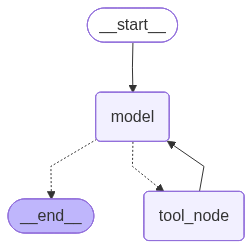

In [40]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [42]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='109e46c6-f1f2-4c0e-bcdf-50199eac4761'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qby6bb00x', 'function': {'arguments': '{"query":"next SpaceX launch","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1690, 'total_tokens': 1714, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.117091561, 'prompt_time': 0.619510665, 'completion_time': 0.049524338, 'total_time': 0.669035003}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'id': 'chatcmpl-a37002f1-8dca-4871-be56-8522c9ba1bb6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5aa16e49-41e1-447e-93c3-a4b6487d7991-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'next SpaceX launch'